# 🌲 PINECONe Demo - Complete Workflow
## Pine Ecosystem Carbon and Economics RX Fire Analysis

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/NASA-EarthRISE/PINECONe/blob/main/PINECONe_Demo.ipynb)
[![GitHub](https://img.shields.io/badge/GitHub-Repository-blue)](https://github.com/NASA-EarthRISE/PINECONe)

This notebook demonstrates the complete PINECONe workflow with **dynamic parameterization**:

1. **📊 Biomass Statistics** - Calculate AGB for focal species (e.g., Longleaf Pine)
2. **💨 Carbon Emissions** - Estimate CO₂ emissions from biomass change  
3. **💧 Water Yield** - Calculate ecosystem services value
4. **💰 Economic Valuation** - Total Econimic Valution (TEV) with Monte Carlo uncertainty

---

**Features:**
- ✅ Automated data integration across all scripts
- ✅ User-customizable economic parameters per zone
- ✅ Monte Carlo uncertainty quantification (10,000+ simulations)
- ✅ Professional visualizations
- ✅ Export to CSV and Google Drive

**Authors:**
- Tim Mayer NASA EarthRISE
- Katie Walker NASA EarthRISE
- Reetwika Basu NASA EarthRISE

**License:** MIT


## 📦 Step 1: Setup & Installation

Install PINECONe and authenticate with Google Earth Engine.

In [1]:
# Install PINECONe package from GitHub
!pip install git+https://github.com/NASA-EarthRISE/PINECONe.git -q

print("✓ PINECONe installed successfully!")

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.0 MB/s eta 0:00:00
✓ PINECONe installed successfully!


In [2]:
import ee
import geemap
import geemap.chart as chart
ee.Authenticate()
ee.Initialize(project='add your GEE project here') #### add your GEE project here
Map = geemap.Map()

## 📚 Step 2: Import Libraries

In [3]:
# Import PINECONe modules
from pinecone.data.biomass import BiomassData
from pinecone.data.focal_species import FocalSpeciesLayer
from pinecone.carbon.biomass_stats import BiomassStatsCalculator
from pinecone.carbon.biomass_change import BiomassChangeCalculator
from pinecone.ecosystem.water_yield import WaterYieldCalculator
from pinecone.economics.tev_calculator import (
    TEVCalculator,
    create_user_params_template
)

# Other libraries
import pandas as pd
import matplotlib.pyplot as plt

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


## ⚙️ Step 3: Configuration

**Customize these parameters for your analysis!**

All parameters can be modified to analyze different:
- Study areas
- Time periods
- Species
- Economic scenarios

In [4]:
# =============================================================================
# USER CONFIGURATION - MODIFY THESE PARAMETERS
# =============================================================================

print("📋 Configuring analysis parameters...\n")

# 1. STUDY AREAS (Areas of Interest)
USE_EXAMPLE_AOIS = True  # Set to False to upload your own

if USE_EXAMPLE_AOIS:
    # Example: EarthRISE case study areas in Alabama
    aois = {
        'EIA_CS1': ee.FeatureCollection('projects/servir-sco-assets/assets/Rx_Fire/Vector_Data/EIA_CS1'),
        'EIA_CS2': ee.FeatureCollection('projects/servir-sco-assets/assets/Rx_Fire/Vector_Data/EIA_CS2'),
        'EIA_CS3': ee.FeatureCollection('projects/servir-sco-assets/assets/Rx_Fire/Vector_Data/EIA_CS3'),
        'EIA_CS4': ee.FeatureCollection('projects/servir-sco-assets/assets/Rx_Fire/Vector_Data/EIA_CS4'),
    }

    # Acres for each AOI (for TEV calculation)
    case_acres = {
        'EIA_CS1_LLP': 651.06,
        'EIA_CS2_LLP': 937.02,
        'EIA_CS3_LLP': 544.03,
        'EIA_CS4_LLP': 501.98
    }
else:
    # Upload your own files
    print("Upload your shapefile or GeoJSON...")
    # TODO: Add file upload code

# 2. FOCAL SPECIES LAYER
focal_species_asset = "projects/servir-sco-assets/assets/Rx_Fire/EO_Inputs/LEO_extantLLP_significance"
focal_species_name = "Longleaf Pine (LLP)"
focal_species_threshold = 0

# 3. BIOMASS DATA SOURCE
biomass_product = 'esa_cci_agb'  # Options: 'esa_cci_agb', 'gedi_l4b', 'whrc'
biomass_year = 2019

# 4. EMISSIONS TIME PERIODS
pre_fire_start = '2018-01-01'   # Before fire
pre_fire_end = '2018-12-31'
post_fire_start = '2019-01-01'  # After fire
post_fire_end = '2019-12-31'

# 5. WATER YIELD TIME PERIOD
water_yield_start = '2019-01-01'  # Post-fire period
water_yield_end = '2019-12-31'

# 6. ECONOMIC PARAMETERS
carbon_fraction = 0.51  # Carbon content of biomass
carbon_credit_price = 10.0  # $/ton CO2e
water_price_per_kl = 0.018  # $/kL water
num_monte_carlo_sims = 10000  # Number of simulations

print(f"✓ Study areas: {len(aois)}")
print(f"✓ Focal species: {focal_species_name}")
print(f"✓ Biomass product: {biomass_product} ({biomass_year})")
print(f"✓ Emissions period: {pre_fire_start} to {post_fire_end}")
print(f"✓ Water yield period: {water_yield_start} to {water_yield_end}")
print(f"✓ Carbon credit price: ${carbon_credit_price}/ton CO2e")
print(f"✓ Monte Carlo simulations: {num_monte_carlo_sims:,}")

📋 Configuring analysis parameters...

✓ Study areas: 4
✓ Focal species: Longleaf Pine (LLP)
✓ Biomass product: esa_cci_agb (2019)
✓ Emissions period: 2018-01-01 to 2019-12-31
✓ Water yield period: 2019-01-01 to 2019-12-31
✓ Carbon credit price: $10.0/ton CO2e
✓ Monte Carlo simulations: 10,000


## 📊 Step 4: Script 1 - Biomass Statistics

Calculate above-ground biomass (AGB) for:
- Focal species areas (e.g., Longleaf Pine)
- Non-focal species areas

**Outputs:**
- Mean biomass per acre ± std dev
- Total biomass (tons)
- Area statistics (acres)

In [5]:
print("📊 SCRIPT 1: Biomass Statistics")
print("="*60)

# Initialize focal species layer
print("\n🌲 Loading focal species layer...")
focal_species = FocalSpeciesLayer(
    layer_source=focal_species_asset,
    binary_threshold=focal_species_threshold,
    name=focal_species_name
)
print(f"✓ Loaded: {focal_species.name}")

# Initialize biomass data
print(f"\n📊 Loading biomass data...")
biomass = BiomassData(
    product=biomass_product,
    year=biomass_year
)
print(f"✓ Loaded: {biomass.product} ({biomass.year})")

# Create calculator
calculator_biomass = BiomassStatsCalculator(biomass)

# Process each AOI
print("\n🔄 Processing AOIs...")
all_stats_list = []

for aoi_name, aoi_fc in aois.items():
    print(f"  Processing {aoi_name}...")

    # Vectorize focal species
    species_vectors = focal_species.vectorize(aoi_fc, scale=30)
    species_dissolved = species_vectors.union(1)

    # Get non-species areas
    non_species = focal_species.get_non_species_areas(
        aoi_fc,
        species_dissolved.geometry()
    )

    # Calculate stats
    stats_species = calculator_biomass.calculate_stats(
        species_vectors,
        f"{aoi_name}_LLP"
    )

    stats_non_species = calculator_biomass.calculate_stats(
        non_species,
        f"{aoi_name}_NonLLP"
    )

    all_stats_list.append(stats_species.merge(stats_non_species))

# Combine all zones
all_stats = all_stats_list[0]
for stats in all_stats_list[1:]:
    all_stats = all_stats.merge(stats)

# Calculate zone summaries
zone_summary = calculator_biomass.calculate_zone_summary(all_stats)
biomass_results = zone_summary.getInfo()

print("\n✓ Biomass statistics calculated!")

📊 SCRIPT 1: Biomass Statistics

🌲 Loading focal species layer...
✓ Loaded: Longleaf Pine (LLP)

📊 Loading biomass data...
✓ Loaded: esa_cci_agb (2019)

🔄 Processing AOIs...
  Processing EIA_CS1...
  Processing EIA_CS2...
  Processing EIA_CS3...
  Processing EIA_CS4...

✓ Biomass statistics calculated!



📈 BIOMASS STATISTICS RESULTS


,Zone,Mean AGB (tons/acre),Std Dev (tons/acre),Total Area (acres),Total Biomass (tons)
0,EIA_CS1_LLP,68.11,3.70,651.06,41391.59
1,EIA_CS1_NonLLP,93.84,0.10,627.46,58879.37
2,EIA_CS2_LLP,64.82,3.30,937.02,62438.39
3,EIA_CS2_NonLLP,68.95,0.03,1743.25,120196.25
4,EIA_CS3_LLP,46.05,0.14,544.03,25052.85
5,EIA_CS3_NonLLP,87.77,0.16,485.41,42603.40
6,EIA_CS4_LLP,85.91,1.21,501.98,43749.02
7,EIA_CS4_NonLLP,81.36,0.09,706.62,57490.70


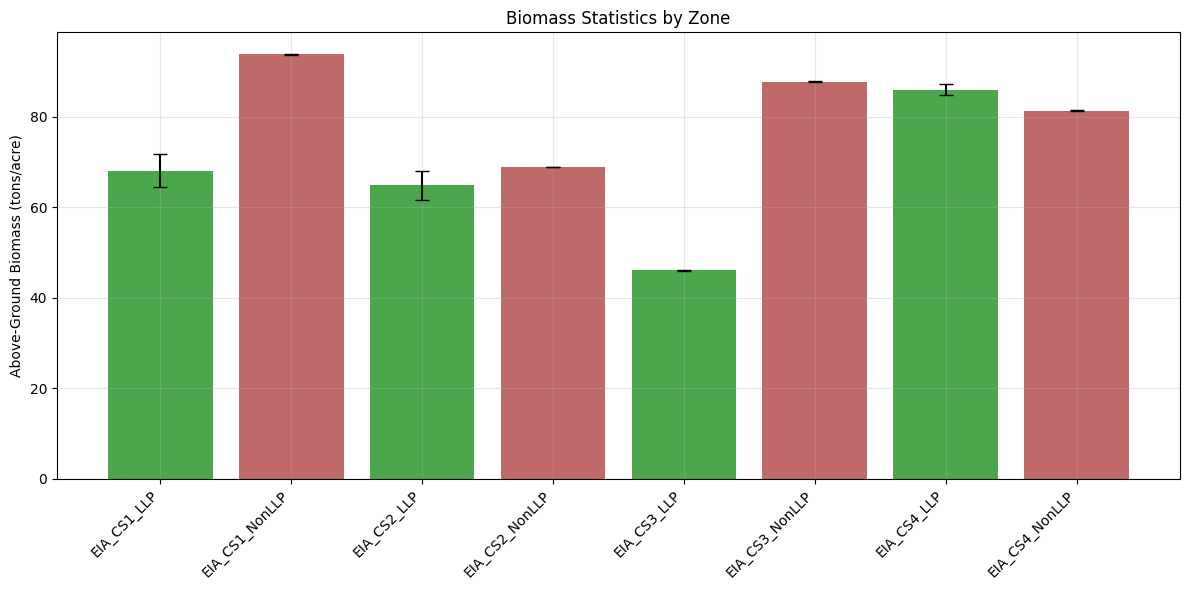


✓ Processed 4 LLP zones for TEV calculation


In [6]:
# Display results
print("\n📈 BIOMASS STATISTICS RESULTS")
print("="*60)

biomass_stats_dict = {}
results_data = []

for feature in biomass_results['features']:
    props = feature['properties']
    zone = props['AOI_Zone']

    results_data.append({
        'Zone': zone,
        'Mean AGB (tons/acre)': f"{props['mean_AGB_per_acre_tons']:.2f}",
        'Std Dev (tons/acre)': f"{props['mean_StdDev_per_acre_tons']:.2f}",
        'Total Area (acres)': f"{props['total_area_acres']:.2f}",
        'Total Biomass (tons)': f"{props['total_biomass_tons']:.2f}"
    })

    # Store for TEV calculation (LLP zones only)
    if 'LLP' in zone and 'NonLLP' not in zone:
        biomass_stats_dict[zone] = {
            'AGB_per_acre_tons': props['mean_AGB_per_acre_tons'],
            'AGB_StdDev_per_acre_tons': props['mean_StdDev_per_acre_tons']
        }

# Create DataFrame
biomass_df = pd.DataFrame(results_data)
display(biomass_df)

# Plot comparison
fig, ax = plt.subplots(figsize=(12, 6))
x = range(len(biomass_df))
agb_values = [float(v) for v in biomass_df['Mean AGB (tons/acre)']]
std_values = [float(v) for v in biomass_df['Std Dev (tons/acre)']]

ax.bar(x, agb_values, yerr=std_values, capsize=5, alpha=0.7,
       color=['green' if 'LLP' in z and 'NonLLP' not in z else 'brown' for z in biomass_df['Zone']])
ax.set_xticks(x)
ax.set_xticklabels(biomass_df['Zone'], rotation=45, ha='right')
ax.set_ylabel('Above-Ground Biomass (tons/acre)')
ax.set_title('Biomass Statistics by Zone')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n✓ Processed {len(biomass_stats_dict)} LLP zones for TEV calculation")

## 💨 Step 5: Script 2 - Carbon Emissions

Calculate carbon emissions from biomass change between two periods.

**Features:**
- Quality filtering (excludes improbable changes)
- Converts biomass change to CO₂ emissions
- Quantifies uncertainty with standard deviation

**Interpretation:**
- Negative values = Carbon sequestration (biomass gain)
- Positive values = Carbon emissions (biomass loss)

In [7]:
print("\n💨 SCRIPT 2: Carbon Emissions")
print("="*60)

# Initialize emissions calculator
print("\nCalculating carbon emissions...")
emissions_calculator = BiomassChangeCalculator(
    biomass_data=None,
    focal_species=focal_species,
    carbon_fraction=carbon_fraction,
    credit_price_per_ton=1.0
)

# Calculate emissions
emissions_fc = emissions_calculator.calculate_for_multiple_aois(
    aois=aois,
    pre_date_start=pre_fire_start,
    pre_date_end=pre_fire_end,
    post_date_start=post_fire_start,
    post_date_end=post_fire_end,
    resolution=100,
    apply_quality_filter=True
)

emissions_results = emissions_fc.getInfo()
print("\n✓ Carbon emissions calculated!")


💨 SCRIPT 2: Carbon Emissions

Calculating carbon emissions...
   Processing EIA_CS1...
      ✓ EIA_CS1: -97847.44 tons CO2
   Processing EIA_CS2...
      ✓ EIA_CS2: -88083.27 tons CO2
   Processing EIA_CS3...
      ✓ EIA_CS3: -63744.96 tons CO2
   Processing EIA_CS4...
      ✓ EIA_CS4: -38202.51 tons CO2

✓ Carbon emissions calculated!



📈 CARBON EMISSIONS RESULTS


,Zone,CO2 (tons/acre),Std Dev (tons/acre),Total CO2 (tons)
0,EIA_CS1_LLP,-150.29,94.71,-97847.44
1,EIA_CS2_LLP,-94.00,75.65,-88083.27
2,EIA_CS3_LLP,-117.17,75.89,-63744.96
3,EIA_CS4_LLP,-76.10,101.89,-38202.51


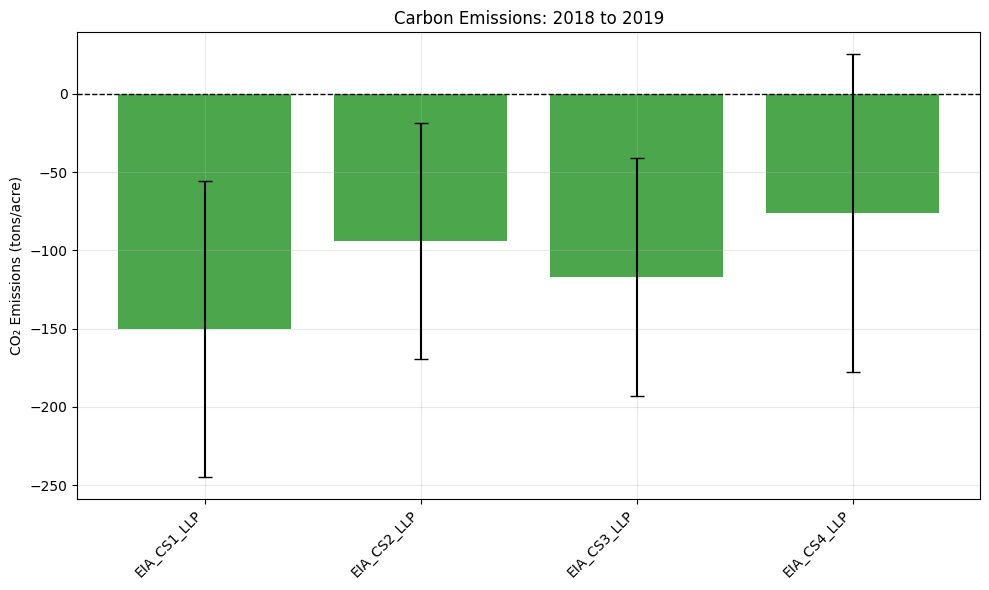


💡 Negative = Sequestration (gain) | Positive = Emissions (loss)


In [8]:
# Display results
print("\n📈 CARBON EMISSIONS RESULTS")
print("="*60)

emissions_stats_dict = {}
emissions_data = []

for feature in emissions_results['features']:
    props = feature['properties']
    zone = props['AOI_Zone']
    zone_llp = f"{zone}_LLP"
    
    emissions_data.append({
        'Zone': zone_llp,
        'CO2 (tons/acre)': f"{props['CO2_mean_tons_per_acre']:.2f}",
        'Std Dev (tons/acre)': f"{props.get('CO2_std_tons_per_acre', 0):.2f}",
        'Total CO2 (tons)': f"{props['CO2_total_tons']:.2f}"
    })
    
    emissions_stats_dict[zone_llp] = {
        'CO2_mean_tons_per_acre': props['CO2_mean_tons_per_acre'],
        'CO2_std_tons_per_acre': props.get('CO2_std_tons_per_acre', 0)
    }

emissions_df = pd.DataFrame(emissions_data)
display(emissions_df)

# Plot emissions (flip sign so sequestration shows as positive gain)
fig, ax = plt.subplots(figsize=(10, 6))
x = range(len(emissions_df))
co2_values = [float(v) for v in emissions_df['CO2 (tons/acre)']]
std_values = [float(v) for v in emissions_df['Std Dev (tons/acre)']]

# Flip the sign: negative emissions (sequestration) become positive bars
co2_values_flipped = [-val for val in co2_values]
colors = ['green' if val > 0 else 'red' for val in co2_values_flipped]

ax.bar(x, co2_values_flipped, yerr=std_values, capsize=5, alpha=0.7, color=colors)
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax.set_xticks(x)
ax.set_xticklabels(emissions_df['Zone'], rotation=45, ha='right')
ax.set_ylabel('Carbon Emissions (tons CO₂/acre)')
ax.set_title(f'Carbon Emissions: {pre_fire_start[:4]} to {post_fire_start[:4]}')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 Positive bars = Carbon emissions (biomass loss)")
print("💡 Negative bars = Carbon sequestration (biomass gain)")

## 💧 Step 6: Script 4 - Water Yield (Ecosystem Services)

Calculate water yield value for ecosystem services.

**Formula:** Water Yield = Precipitation - Evapotranspiration

**Data Sources:**
- MODIS ET (Evapotranspiration)
- PRISM (Precipitation)

**Note:** May fail if data unavailable for your date range. Script will use default values and continue.

In [9]:
print("\n💧 SCRIPT 4: Water Yield")
print("="*60)

water_calculator = WaterYieldCalculator(
    water_price_per_kl=water_price_per_kl,
    et_scale_factor=0.01
)

print("\nCalculating water yield...")
print("(Clipping to LLP areas for consistency)")
print("(May fail if ET/precipitation data unavailable)")

try:
    # Create LLP-clipped AOIs for water yield calculation
    llp_aois = {}
    
    for aoi_name, aoi_fc in aois.items():
        print(f"  Creating LLP geometry for {aoi_name}...")
        
        # Vectorize and dissolve LLP areas (same as Script 1)
        species_vectors = focal_species.vectorize(aoi_fc, scale=30)
        species_dissolved = species_vectors.union(1)
        
        # Use dissolved LLP geometry as AOI for water yield
        llp_aois[aoi_name] = species_dissolved
    
    # Calculate water yield for LLP areas only
    water_yield_results = water_calculator.calculate_for_multiple_aois(
        aois=llp_aois,  # Use LLP-clipped geometries
        start_date=water_yield_start,
        end_date=water_yield_end,
        scale=500
    )
    
    successful = sum(1 for v in water_yield_results.values() if v is not None)
    
    if successful > 0:
        print(f"\n✓ Water yield calculated for {successful}/{len(aois)} LLP areas")
    else:
        print("\n⚠️  All calculations failed - using defaults")
        water_yield_results = None
        
except Exception as e:
    print(f"\n⚠️  Water yield failed: {e}")
    print("    Using default water quality values")
    water_yield_results = None


💧 SCRIPT 4: Water Yield

Calculating water yield...
(May fail if ET/precipitation data unavailable)
  Calculating water yield for EIA_CS1...
    ✓ Water yield: $38.81/acre
  Calculating water yield for EIA_CS2...
    ✓ Water yield: $32.42/acre
  Calculating water yield for EIA_CS3...
    ✓ Water yield: $43.36/acre
  Calculating water yield for EIA_CS4...
    ✓ Water yield: $40.03/acre

✓ Water yield calculated for 4/4 AOIs


In [10]:
# Display water yield results if available
if water_yield_results and any(v for v in water_yield_results.values() if v):
    print("\n📈 WATER YIELD RESULTS")
    print("="*60)

    water_data = []
    for zone_name, results in water_yield_results.items():
        if results:
            water_data.append({
                'Zone': zone_name,
                'Water Yield ($/acre)': f"${results['water_yield_per_acre_usd']:.2f}",
                'Std Dev ($/acre)': f"±${results['water_yield_std_per_acre_usd']:.2f}",
                'Total Value ($)': f"${results['total_water_yield_usd']:.2f}"
            })

    if water_data:
        water_df = pd.DataFrame(water_data)
        display(water_df)
else:
    print("\n⚠️  No water yield data available")
    print("    TEV will use default: $100.00/acre ± $2.00")


📈 WATER YIELD RESULTS


,Zone,Water Yield ($/acre),Std Dev ($/acre),Total Value ($)
0,EIA_CS1,$38.81,±$4.44,$49442.88
1,EIA_CS2,$32.42,±$8.56,$86747.45
2,EIA_CS3,$43.36,±$8.09,$44595.43
3,EIA_CS4,$40.03,±$8.26,$48380.76


## ⚙️ Step 7: Define Economic Parameters

**This is where you customize the analysis.**

Specify the economic parameters for each management zone:

### Economic Inputs
- **E_Pt** — Stumpage price *(USD / ton)* ± standard deviation  
- **g** — Regeneration cost *(USD / acre)* ± standard deviation  
- **endangered_species_WTP** — Willingness-to-pay for endangered species *(USD / acre)*  

### Lease Parameters
- **R_t_lease** — Annual lease revenue *(USD / acre / year)*  
- **T_lease** — Lease period *(years)*  
- **r_lease** — Discount rate *(decimal form, e.g., 0.05)*  


### Example Scenarios
- **CS1: Severe Wildfire**  
  High costs, low revenues  

- **CS2: Mitigated Wildfire**  
  Moderate costs and revenues  

- **CS3: Prescribed Burn**  
  Low costs, high revenues  


In [17]:
print("⚙️  DEFINING ECONOMIC PARAMETERS")
print("="*60)

# Customize these parameters for your scenarios!
user_params = {
    "EIA_CS1_LLP": {
        # Severe wildfire scenario
        'E_Pt': (7.50, 1.0),       # Low stumpage price
        'g': (375, 50),             # High regeneration cost
        'endangered_species_WTP': (13.37 * 0.1, 1),  # Low species value
        'R_t_lease': [50, 20, 0, 0, 0],  # Declining revenues
        'T_lease': 5,
        'r_lease': 0.06,            # Higher risk
        'epsilon_t': 0
    },
    "EIA_CS2_LLP": {
        # Managed wildfire scenario
        'E_Pt': (21, 3),            # Moderate price
        'g': (200, 30),             # Moderate cost
        'endangered_species_WTP': (13.37 * 0.4, 2),
        'R_t_lease': [200, 100, 50, 20, 10],
        'T_lease': 5,
        'r_lease': 0.055,
        'epsilon_t': 0
    },
    "EIA_CS3_LLP": {
        # Prescribed burn scenario
        'E_Pt': (36, 5),            # High timber price
        'g': (50, 10),              # Low regeneration cost
        'endangered_species_WTP': (13.37 * 1, 3),  # Full species value
        'R_t_lease': [300, 700, 700, 700, 700],  # High stable revenues
        'T_lease': 5,
        'r_lease': 0.05,            # Lower risk
        'epsilon_t': 0
    },
     "EIA_CS4_LLP": {
        # No burn
        'E_Pt': (29, 5),            # High timber price
        'g': (50, 10),              # Low regeneration cost
        'endangered_species_WTP': (13.37 * 0.7, 2),  # Full species value
        'R_t_lease': [200, 200, 200, 200, 200],  # High stable revenues
        'T_lease': 5,
        'r_lease': 0.07,            # Lower risk
        'epsilon_t': 0
    }
}

print("\nEconomic parameters defined:\n")
for zone_name, params in user_params.items():
    print(f"{zone_name}:")
    print(f"  Stumpage: ${params['E_Pt'][0]:.2f}/ton ± ${params['E_Pt'][1]:.2f}")
    print(f"  Regen cost: ${params['g'][0]:.2f}/acre ± ${params['g'][1]:.2f}")
    print(f"  Species WTP: ${params['endangered_species_WTP'][0]:.2f}/acre")
    print(f"  Lease revenues: {params['R_t_lease']}\n")

print("✓ Ready for TEV calculation")

⚙️  DEFINING ECONOMIC PARAMETERS

Economic parameters defined:

EIA_CS1_LLP:
  Stumpage: $7.50/ton ± $1.00
  Regen cost: $375.00/acre ± $50.00
  Species WTP: $1.34/acre
  Lease revenues: [50, 20, 0, 0, 0]

EIA_CS2_LLP:
  Stumpage: $21.00/ton ± $3.00
  Regen cost: $200.00/acre ± $30.00
  Species WTP: $5.35/acre
  Lease revenues: [200, 100, 50, 20, 10]

EIA_CS3_LLP:
  Stumpage: $36.00/ton ± $5.00
  Regen cost: $50.00/acre ± $10.00
  Species WTP: $13.37/acre
  Lease revenues: [300, 700, 700, 700, 700]

EIA_CS4_LLP:
  Stumpage: $29.00/ton ± $5.00
  Regen cost: $50.00/acre ± $10.00
  Species WTP: $9.36/acre
  Lease revenues: [200, 200, 200, 200, 200]

✓ Ready for TEV calculation


## 💰 Step 8: Script 3 - Total Economic Value (TEV)

Calculate TEV by integrating all components:

**TEV = Timber Value + Carbon Credits + Ecosystem Services + Land Value**

Where:
- **Timber Value** = (Stumpage Price × Biomass) - Regeneration Cost
- **Carbon Credits** = CO₂ Change × Credit Price  
- **Ecosystem Services** = Water Yield + Species WTP
- **Land Value** = NPV of Lease Revenues

**Monte Carlo Simulation:**
- Runs 10,000+ simulations
- Accounts for uncertainty in all parameters
- Provides mean, median, and confidence intervals

In [18]:
print("\n💰 SCRIPT 3: Total Economic Value (TEV)")
print("="*60)

# Initialize TEV calculator
tev_calculator = TEVCalculator(random_seed=42)

print(f"\nRunning {num_monte_carlo_sims:,} Monte Carlo simulations...")
print("Integrating: Biomass + Emissions + Water Yield + User Parameters")
print("(This may take 1-2 minutes)\n")

# Run TEV calculation with all integrated data
tev_results = tev_calculator.run_monte_carlo(
    biomass_stats=biomass_stats_dict,
    emissions_stats=emissions_stats_dict,
    case_acres=case_acres,
    water_yield_stats=water_yield_results,
    user_params=user_params,
    carbon_credit_price=carbon_credit_price,
    num_simulations=num_monte_carlo_sims
)

print("\n✓ TEV calculations complete!")


💰 SCRIPT 3: Total Economic Value (TEV)

Running 10,000 Monte Carlo simulations...
Integrating: Biomass + Emissions + Water Yield + User Parameters
(This may take 1-2 minutes)

  Running 10,000 simulations for EIA_CS1_LLP...
  Running 10,000 simulations for EIA_CS2_LLP...
  Running 10,000 simulations for EIA_CS3_LLP...
  Running 10,000 simulations for EIA_CS4_LLP...

✓ TEV calculations complete!


In [19]:
# Display results
print("\n📊 TOTAL ECONOMIC VALUE (TEV) RESULTS")
print("="*60)

# Format for display
display_df = tev_results.copy()
for col in ['Mean_TEV', 'Std_TEV', 'Median_TEV', 'Q25_TEV', 'Q75_TEV', 'Min_TEV', 'Max_TEV']:
    display_df[col] = display_df[col].apply(lambda x: f"${x:,.0f}")
display_df['Acres'] = display_df['Acres'].apply(lambda x: f"{x:,.2f}")

display(display_df)

# Summary interpretation
print("\n💡 Interpretation:")
for _, row in tev_results.iterrows():
    mean_val = row['Mean_TEV']
    case = row['Case']

    if mean_val < 0:
        print(f"  {case}: Net economic LOSS (${abs(mean_val):,.0f})")
    else:
        print(f"  {case}: Net economic BENEFIT (${mean_val:,.0f})")


📊 TOTAL ECONOMIC VALUE (TEV) RESULTS


,Case,Acres,Mean_TEV,Std_TEV,Median_TEV,Q25_TEV,Q75_TEV,Min_TEV,Max_TEV
0,EIA_CS1_LLP,651.06,"$-833,379","$621,172","$-834,232","$-1,256,196","$-416,670","$-3,499,226","$1,952,191"
1,EIA_CS2_LLP,937.02,"$564,313","$732,058","$573,704","$69,276","$1,059,446","$-2,172,070","$3,506,706"
2,EIA_CS3_LLP,544.03,"$1,710,436","$427,072","$1,709,594","$1,418,606","$1,996,671","$196,261","$3,300,199"
3,EIA_CS4_LLP,501.98,"$1,283,097","$561,543","$1,283,618","$901,191","$1,666,302","$-1,027,396","$3,860,158"



💡 Interpretation:
  EIA_CS1_LLP: Net economic LOSS ($833,379)
  EIA_CS2_LLP: Net economic BENEFIT ($564,313)
  EIA_CS3_LLP: Net economic BENEFIT ($1,710,436)
  EIA_CS4_LLP: Net economic BENEFIT ($1,283,097)


## 📊 Step 9: Visualizations

Generate professional visualizations of your results.

📈 Generating visualizations...

1. TEV Probability Distributions


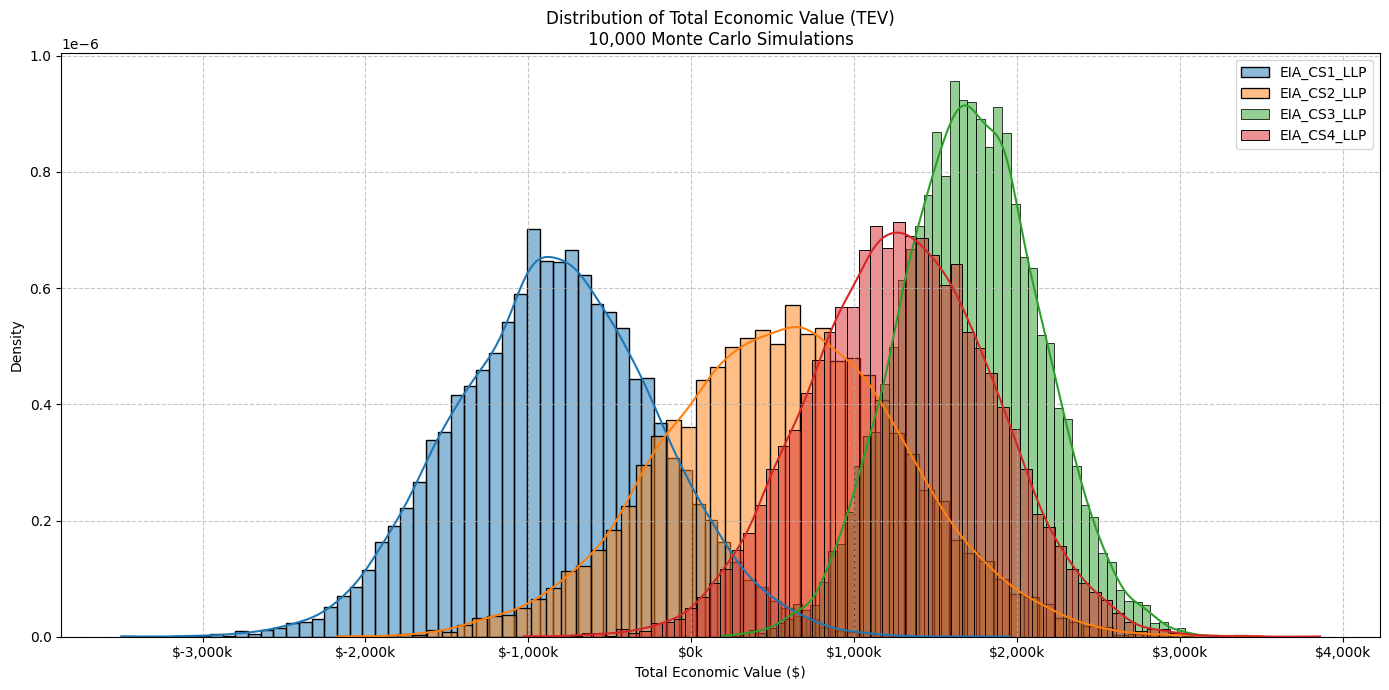


2. TEV Scenario Comparison


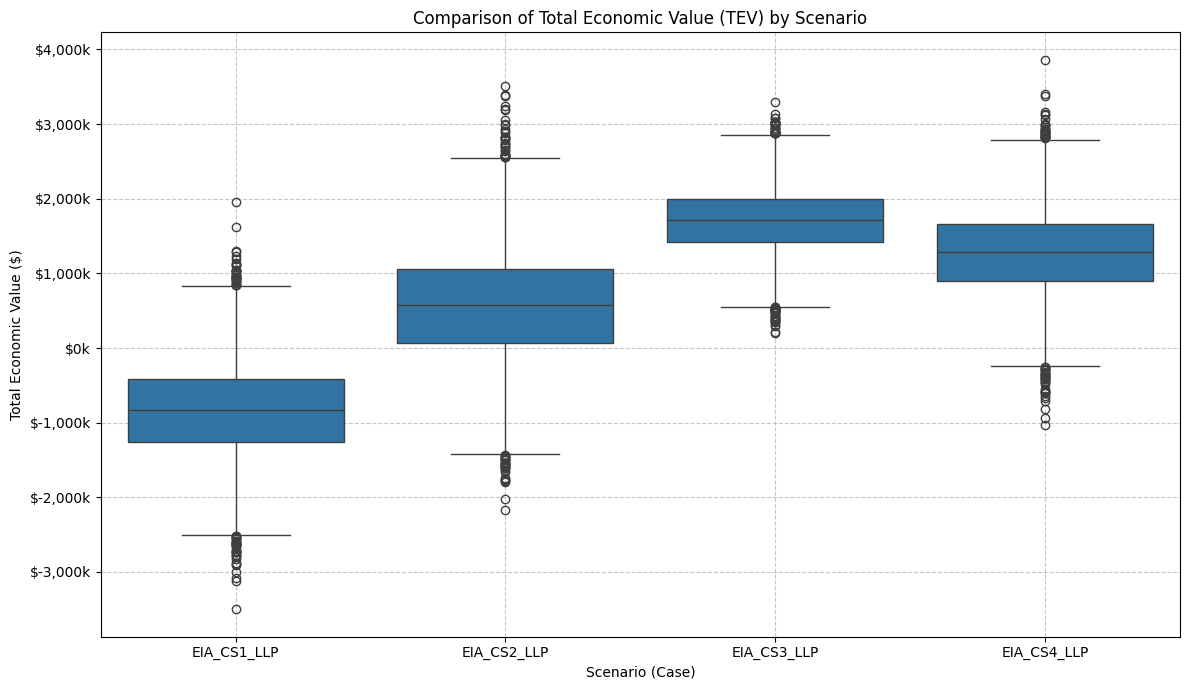


✓ Visualizations complete!


In [20]:
print("📈 Generating visualizations...\n")

# Distribution plot
print("1. TEV Probability Distributions")
tev_calculator.plot_distributions(
    title=f'Distribution of Total Economic Value (TEV)\n{num_monte_carlo_sims:,} Monte Carlo Simulations'
)

# Boxplot comparison
print("\n2. TEV Scenario Comparison")
tev_calculator.plot_boxplots(
    title='Comparison of Total Economic Value (TEV) by Scenario'
)

print("\n✓ Visualizations complete!")

## 💾 Step 10: Export Results

Save your results to Google Drive or download as CSV.

In [21]:
print("💾 EXPORTING RESULTS")
print("="*60)

# Export to current directory
tev_calculator.export_results('pinecone_tev_results.csv')

# Optional: Mount Google Drive and save there
print("\n📁 To save to Google Drive:")
print("""
from google.colab import drive
drive.mount('/content/drive')

# Save to Drive
tev_calculator.export_results('/content/drive/MyDrive/PINECONe_Results/tev_results.csv')
""")

💾 EXPORTING RESULTS
Results exported to pinecone_tev_results.csv

📁 To save to Google Drive:

from google.colab import drive
drive.mount('/content/drive')

# Save to Drive
tev_calculator.export_results('/content/drive/MyDrive/PINECONe_Results/tev_results.csv')



## 📋 Step 11: Component Breakdown

Detailed breakdown showing how each data source contributes to TEV.

In [22]:
print("📋 COMPONENT BREAKDOWN")
print("="*60)

print("\nTEV Components:")
print("1. Timber Value (PV) = Stumpage Price × Biomass - Regen Cost")
print("2. Carbon Benefits (PVC) = CO2 Change × Carbon Credit Price")
print("3. Ecosystem Services (PE) = Water Yield + Species WTP")
print("4. Land Value (L) = NPV of Lease Revenues")

for zone_name in user_params.keys():
    if zone_name in biomass_stats_dict and zone_name in emissions_stats_dict:
        print(f"\n{zone_name}:")
        print(f"  📊 Biomass: {biomass_stats_dict[zone_name]['AGB_per_acre_tons']:.2f} tons/acre")
        print(f"  💨 Emissions: {emissions_stats_dict[zone_name]['CO2_mean_tons_per_acre']:.2f} tons CO2/acre")

        base_zone = zone_name.replace('_LLP', '')
        if water_yield_results and base_zone in water_yield_results and water_yield_results[base_zone]:
            print(f"  💧 Water Yield: ${water_yield_results[base_zone]['water_yield_per_acre_usd']:.2f}/acre")
        else:
            print(f"  💧 Water Yield: $100.00/acre (default)")

        print(f"  💰 Stumpage: ${user_params[zone_name]['E_Pt'][0]:.2f}/ton")
        print(f"  🌱 Regen Cost: ${user_params[zone_name]['g'][0]:.2f}/acre")

📋 COMPONENT BREAKDOWN

TEV Components:
1. Timber Value (PV) = Stumpage Price × Biomass - Regen Cost
2. Carbon Benefits (PVC) = CO2 Change × Carbon Credit Price
3. Ecosystem Services (PE) = Water Yield + Species WTP
4. Land Value (L) = NPV of Lease Revenues

EIA_CS1_LLP:
  📊 Biomass: 68.11 tons/acre
  💨 Emissions: -150.29 tons CO2/acre
  💧 Water Yield: $38.81/acre
  💰 Stumpage: $7.50/ton
  🌱 Regen Cost: $375.00/acre

EIA_CS2_LLP:
  📊 Biomass: 64.82 tons/acre
  💨 Emissions: -94.00 tons CO2/acre
  💧 Water Yield: $32.42/acre
  💰 Stumpage: $21.00/ton
  🌱 Regen Cost: $200.00/acre

EIA_CS3_LLP:
  📊 Biomass: 46.05 tons/acre
  💨 Emissions: -117.17 tons CO2/acre
  💧 Water Yield: $43.36/acre
  💰 Stumpage: $36.00/ton
  🌱 Regen Cost: $50.00/acre

EIA_CS4_LLP:
  📊 Biomass: 85.91 tons/acre
  💨 Emissions: -76.10 tons CO2/acre
  💧 Water Yield: $40.03/acre
  💰 Stumpage: $29.00/ton
  🌱 Regen Cost: $50.00/acre


## 🎉 Summary

Congratulations! You've completed the full PINECONe workflow.

### ✅ What You Accomplished:

1. ✅ Calculated biomass statistics for focal species
2. ✅ Estimated carbon emissions from biomass change
3. ✅ Calculated water yield ecosystem services  
4. ✅ Integrated everything into Total Economic Value
5. ✅ Quantified uncertainty with Monte Carlo simulation
6. ✅ Generated professional visualizations
7. ✅ Exported results for further analysis

---

### 🔧 Next Steps:

**Modify Parameters:**
- Scroll back to Step 3 to change study areas or time periods
- Edit Step 7 to test different economic scenarios
- Run from Step 8 onwards to see new results

**Compare Scenarios:**
- Test different carbon credit prices
- Compare management strategies
- Analyze sensitivity to key parameters

**Use Your Own Data:**
- Set `USE_EXAMPLE_AOIS = False` in Step 3
- Upload your own study areas
- Define custom economic parameters

---

### 📚 Resources:

- **GitHub**: https://github.com/NASA-EarthRISE/PINECONe
- **Documentation**: https://nasa-earthrise.github.io/PINECONe/
- **Issues**: https://github.com/NASA-EarthRISE/PINECONe/issues

---

**Citation**: If you use PINECONe in your research, please cite:

```
NASA EarthRISE Team (2025). PINECONe: Pine Ecosystem Carbon and Economics
RX Fire Analysis. https://github.com/NASA-EarthRISE/PINECONe
```

---

**Made with 🌲 by NASA EarthRISE**